In [13]:
import pandas as pd

import os

import tensorflow as tf

import numpy as np

import seaborn as sns

import matplotlib.pyplot as plt

from keras.models import Sequential

from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from sklearn.metrics import f1_score, confusion_matrix, classification_report

from tensorflow.keras.applications import InceptionV3

from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Flatten, Dropout, Dense

from tensorflow.keras.models import Model

from tensorflow.keras.layers import GlobalAveragePooling2D

from tensorflow.keras.models import load_model

from tensorflow.keras.preprocessing import image

from tensorflow.keras.applications.inception_v3 import preprocess_input

In [4]:
data = 'sports.csv'
df = pd.read_csv(data)

In [5]:
class_names = sorted(df['labels'].unique())
num_classes = len(class_names)
class_to_index = {class_name: index for index, class_name in enumerate(class_names)}
df['label_index'] = df['labels'].map(class_to_index)

In [6]:
img_height, img_width = 256, 256
datagen = ImageDataGenerator(rescale=1./255)

In [7]:
# Train-Test-Validation Split

train_df = df[df['data set'] == 'train']
test_df = df[df['data set'] == 'test']
val_df = df[df['data set'] == 'valid']

# Create Data Generators

train_data_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='label_index',
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='raw',
    shuffle=True
)

test_data_gen = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='label_index',
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='raw',
    shuffle=False
)

val_data_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='label_index',
    target_size=(img_height, img_width),
    batch_size=64,
    class_mode='raw',
    shuffle=False
)

Found 13492 validated image filenames.
Found 500 validated image filenames.
Found 500 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


In [ ]:
def f1_score_metric(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    f1_per_class = []
    for class_id in range(100):
        class_true = tf.cast(tf.equal(y_true, class_id), tf.float32)
        class_pred = tf.cast(tf.equal(y_pred, class_id), tf.float32)
        f1 = tf.py_function(lambda y_true, y_pred: f1_score(y_true, y_pred, zero_division=1), (class_true, class_pred), tf.float32)
        f1_per_class.append(f1)
    return tf.reduce_mean(f1_per_class)

# InceptionV3 Model

inception = InceptionV3(
    input_shape=(256, 256, 3), include_top=False, weights="imagenet", classes=100
)
inception.trainable = False

model = Sequential()
model.add(inception)
model.add(Flatten())
model.add(Dropout(0.1))
model.add(Dense(256, activation="leaky_relu"))
model.add(Dropout(0.1))
model.add(Dense(128, activation="leaky_relu"))
model.add(Dropout(0.1))
model.add(Dense(100, activation="softmax"))

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", f1_score_metric]
)

model.summary()

history = model.fit(
    train_data_gen,
    epochs=5,
    batch_size=128,
    validation_data=val_data_gen,
    verbose=1,
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 6, 6, 2048)        21802784  
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dropout (Dropout)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 256)               18874624  
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0

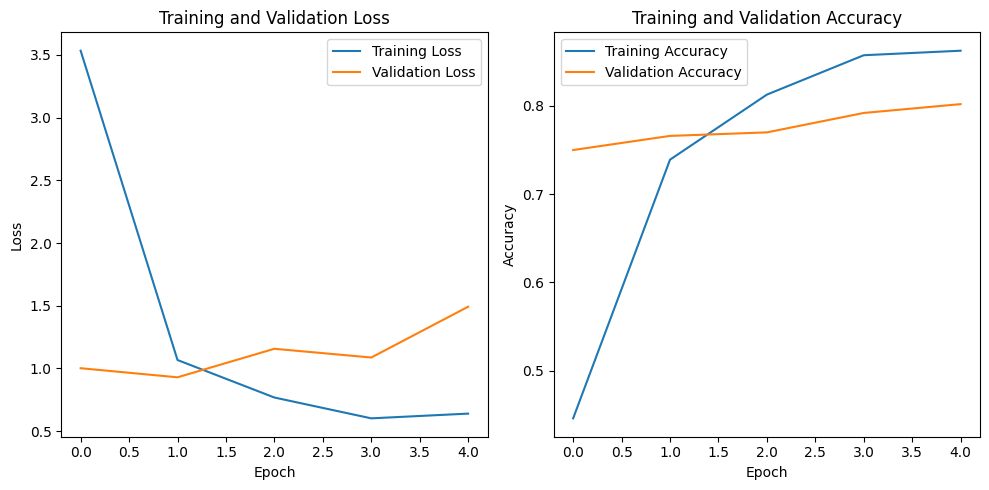

In [ ]:
# Plot training and validation loss

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plot training and validation accuracy

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# InceptionV3 base model

base_model = InceptionV3(
    input_shape=(256, 256, 3), include_top=False, weights="imagenet"
)

# Freeze all layers

for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

fine_tuned_model = Model(inputs=base_model.input, outputs=output)

fine_tuned_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', f1_score_metric])

history_fine_tuned = fine_tuned_model.fit(
    train_data_gen,
    epochs=5,
    batch_size=32,
    validation_data=val_data_gen,
)

Epoch 1/5
211/211 [==============================] - 378s 2s/step - loss: 2.7646 - accuracy: 0.3418 - f1_score_metric: 0.5226 - val_loss: 1.1680 - val_accuracy: 0.7120 - val_f1_score_metric: 0.8457
Epoch 2/5
211/211 [==============================] - 443s 2s/step - loss: 1.4638 - accuracy: 0.5897 - f1_score_metric: 0.6802 - val_loss: 0.8328 - val_accuracy: 0.7820 - val_f1_score_metric: 0.8821
Epoch 3/5
211/211 [==============================] - 419s 2s/step - loss: 1.1554 - accuracy: 0.6721 - f1_score_metric: 0.7377 - val_loss: 0.6679 - val_accuracy: 0.8200 - val_f1_score_metric: 0.8936
Epoch 4/5
211/211 [==============================] - 373s 2s/step - loss: 0.9866 - accuracy: 0.7140 - f1_score_metric: 0.7717 - val_loss: 0.6240 - val_accuracy: 0.8080 - val_f1_score_metric: 0.8874
Epoch 5/5
211/211 [==============================] - 434s 2s/step - loss: 0.8790 - accuracy: 0.7401 - f1_score_metric: 0.7914 - val_loss: 0.5715 - val_accuracy: 0.8240 - val_f1_score_metric: 0.8995


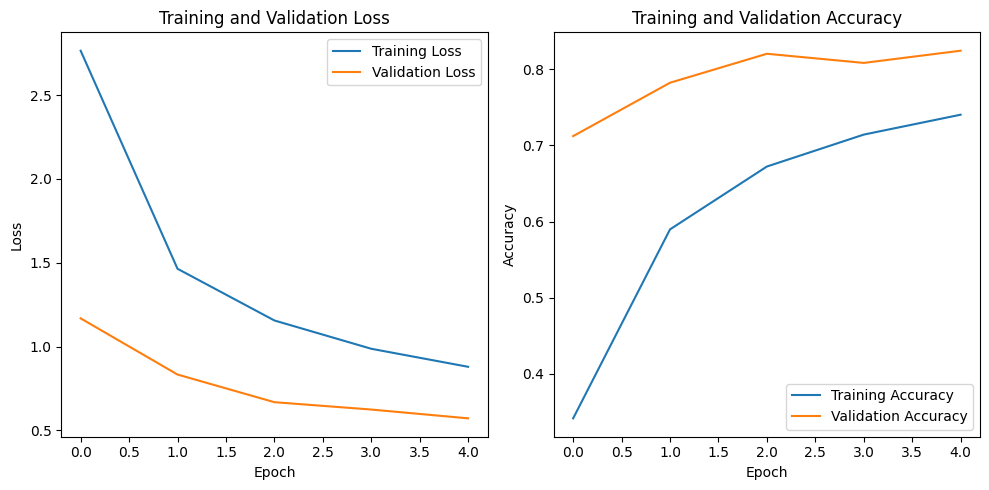

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history_fine_tuned.history['loss'], label='Training Loss')
plt.plot(history_fine_tuned.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fine_tuned.history['accuracy'], label='Training Accuracy')
plt.plot(history_fine_tuned.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
fine_tuned_model.save("InceptionV3.h5")

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1/1 [==============================] - 0s 314ms/step


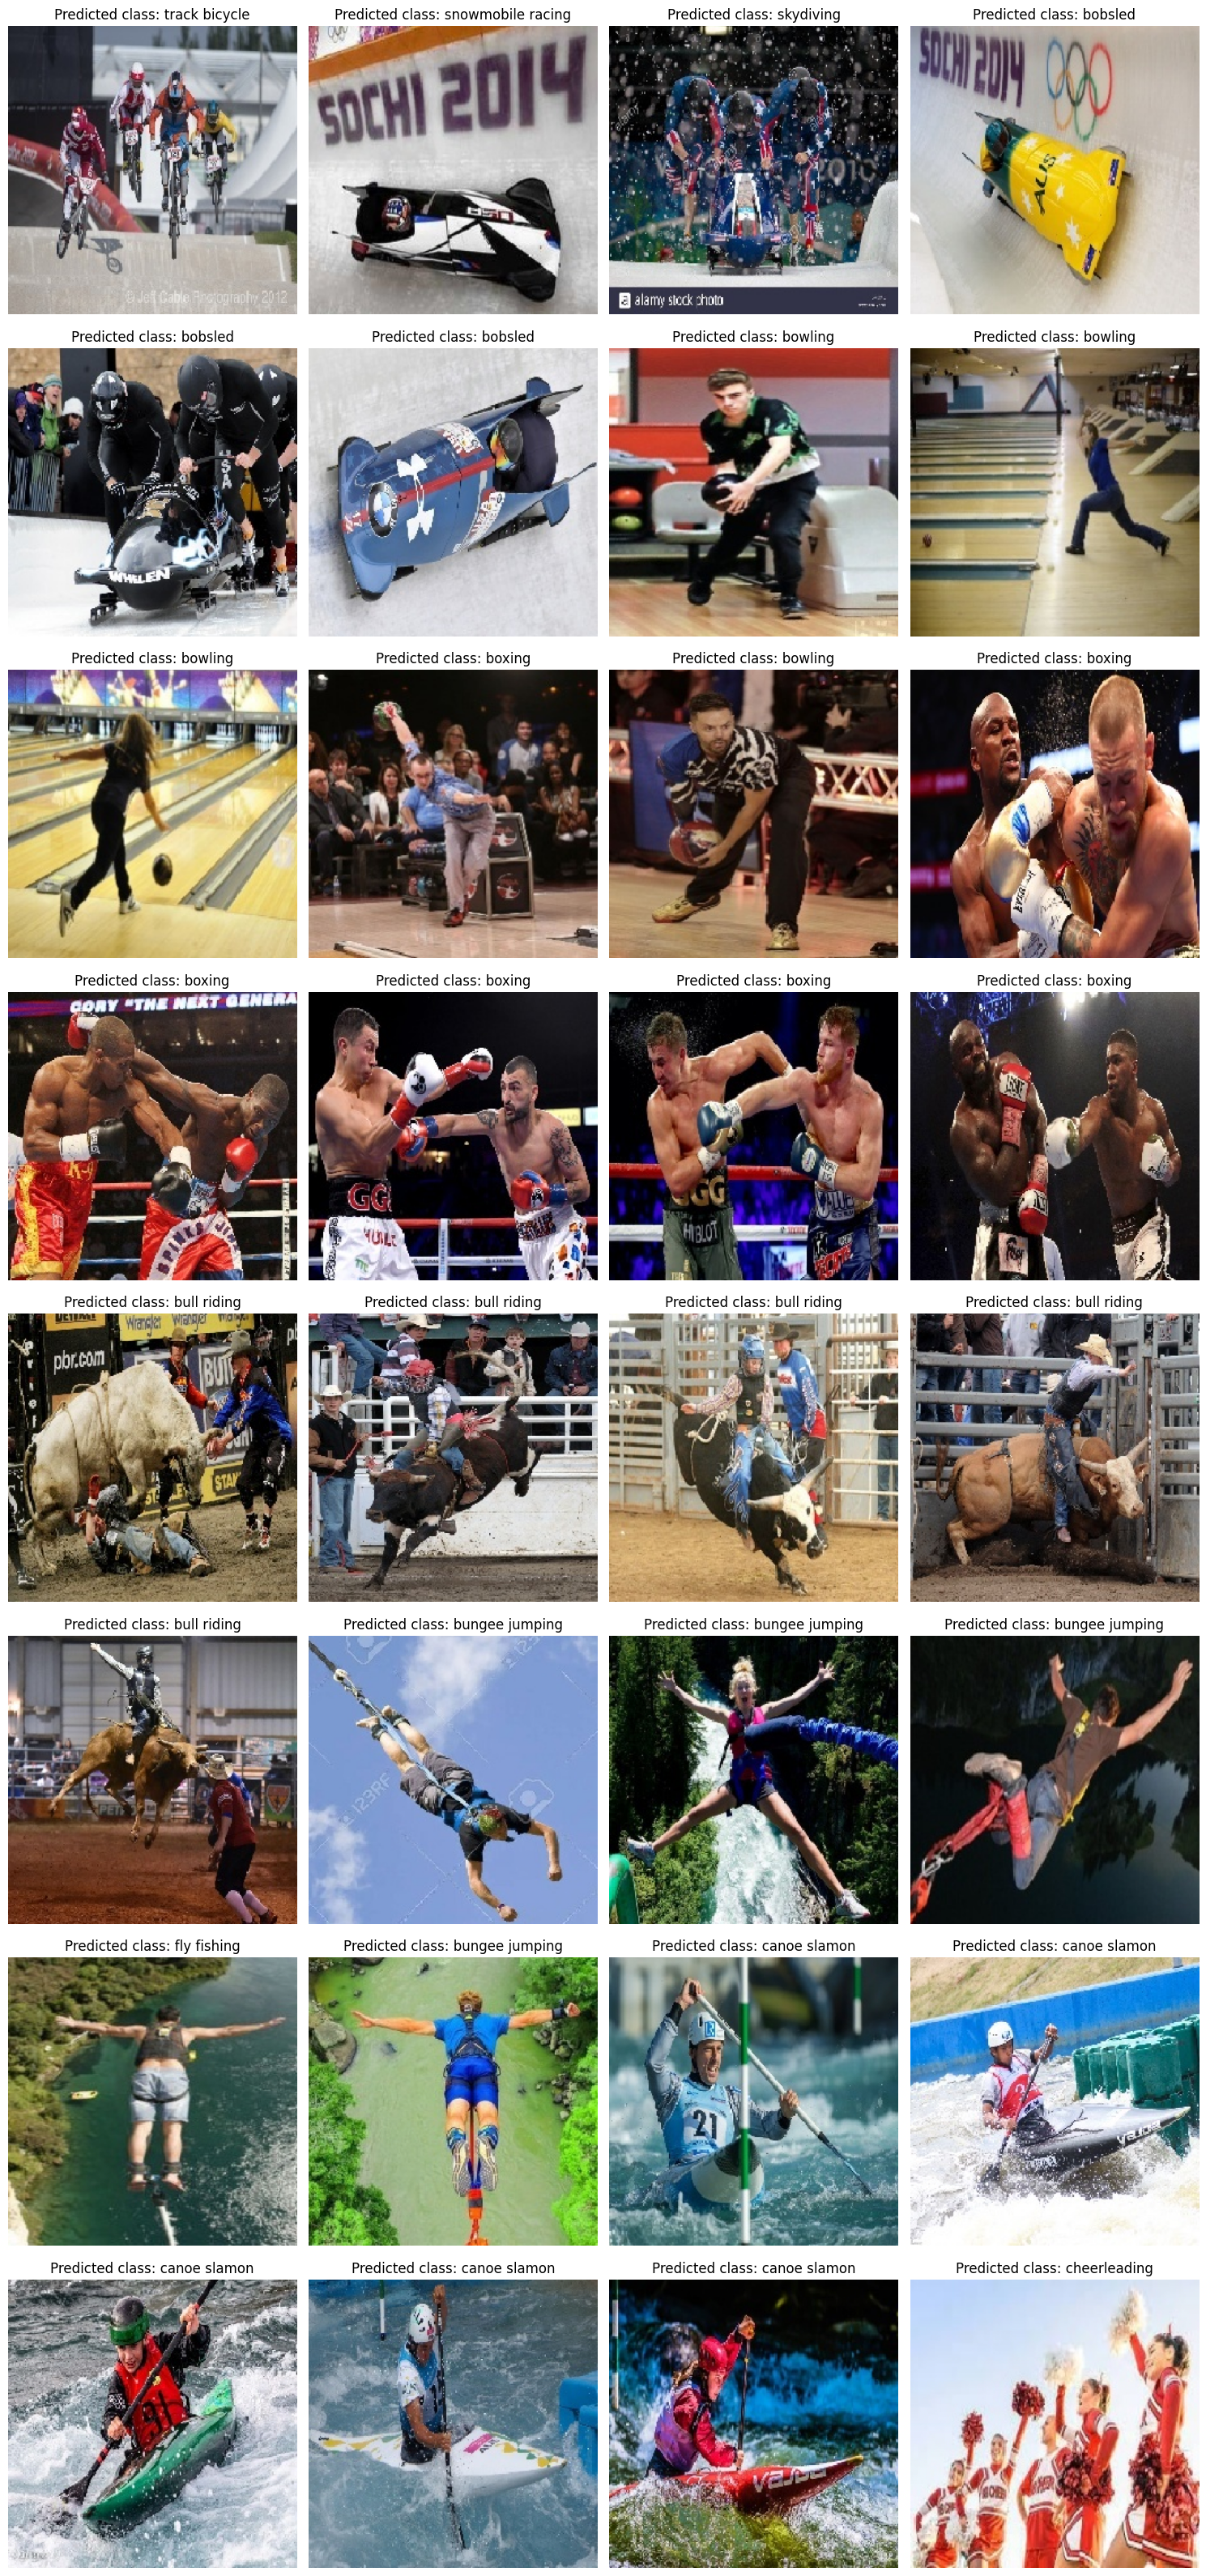

In [9]:
def f1_score_metric(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    f1_per_class = []
    for class_id in range(100):
        class_true = tf.cast(tf.equal(y_true, class_id), tf.float32)
        class_pred = tf.cast(tf.equal(y_pred, class_id), tf.float32)
        f1 = tf.py_function(lambda y_true, y_pred: f1_score(y_true, y_pred, zero_division=1), (class_true, class_pred), tf.float32)
        f1_per_class.append(f1)
    return tf.reduce_mean(f1_per_class)


model = load_model("InceptionV3.h5", custom_objects={'f1_score_metric': f1_score_metric})

# Access the first batch from the validation data generator

batch_images, batch_labels = next(val_data_gen)

# Make predictions and get the index of the predicted class

batch_predictions = model.predict(batch_images)
predicted_class_index = np.argmax(batch_predictions, axis=1)

num_images = 32
num_rows = (num_images + 3) // 4
fig, axs = plt.subplots(num_rows, 4, figsize=(15, 4 * num_rows))


for i in range(num_images):
    row_idx = i // 4
    col_idx = i % 4

    # Image from the batch

    selected_image = batch_images[i]
    resized_image = image.smart_resize(selected_image, (256, 256))

    # Resized image for model prediction

    preprocessed_image = preprocess_input(resized_image)
    predictions = model.predict(np.expand_dims(preprocessed_image, axis=0))

    # Get the corresponding class label from class_names list

    predicted_class_label = class_names[predicted_class_index[i]]

    axs[row_idx, col_idx].imshow(selected_image)
    axs[row_idx, col_idx].set_title(f"Predicted class: {predicted_class_label}")
    axs[row_idx, col_idx].axis('off')

# Remove empty subplots

for i in range(num_images, num_rows * 4):
    row_idx = i // 4
    col_idx = i % 4
    axs[row_idx, col_idx].axis('off')

plt.tight_layout()
plt.show()

8/8 [==============================] - 93s 11s/step
                       precision    recall  f1-score   support

           air hockey       0.71      1.00      0.83         5
      ampute football       0.83      1.00      0.91         5
              archery       0.83      1.00      0.91         5
        arm wrestling       0.83      1.00      0.91         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       0.71      1.00      0.83         5
        barell racing       1.00      1.00      1.00         5
             baseball       0.83      1.00      0.91         5
           basketball       1.00      1.00      1.00         5
       baton twirling       0.57      0.80      0.67         5
            bike polo       0.83      1.00      0.91         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      0.60      0.75         5
              bobsled       1.00      0.60      0.75         5
  

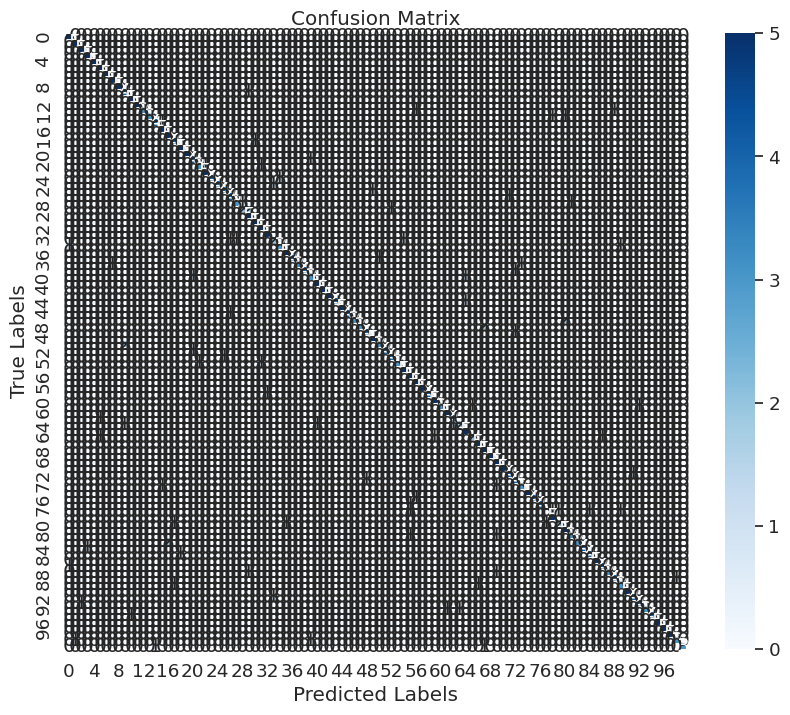

In [14]:
# Create a confusion matrix and a classification report

y_pred = model.predict(val_data_gen)

y_true = val_data_gen.labels

cm = confusion_matrix(y_true, np.argmax(y_pred, axis=-1))

plt.figure(figsize=(10, 8))
sns.set(font_scale=1.2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')

print(classification_report(y_true, np.argmax(y_pred, axis=-1), target_names=class_names))

plt.show()